# 多尺度目标检测

在 `sec_anchor`中，我们以输入图像的每个像素为中心，生成了多个锚框。
基本而言，这些锚框代表了图像不同区域的样本。
然而，如果为每个像素都生成的锚框，我们最终可能会得到太多需要计算的锚框。
想象一个$561 \times 728$的输入图像，如果以每个像素为中心生成五个形状不同的锚框，就需要在图像上标记和预测超过200万个锚框（$561 \times 728 \times 5$）。

## 多尺度锚框

减少图像上的锚框数量并不困难。
比如，我们可以在输入图像中均匀采样一小部分像素，并以它们为中心生成锚框。
此外，在不同尺度下，我们可以生成不同数量和不同大小的锚框。
直观地说，比起较大的目标，较小的目标在图像上出现的可能性更多样。
例如，$1 \times 1$、$1 \times 2$和$2 \times 2$的目标可以分别以4、2和1种可能的方式出现在$2 \times 2$图像上。
因此，当使用较小的锚框检测较小的物体时，我们可以采样更多的区域，而对于较大的物体，我们可以采样较少的区域。

为了演示如何在多个尺度下生成锚框，让我们先读取一张图像。
它的高度和宽度分别为561和728像素。

In [1]:
%matplotlib inline
import torch
from d2l import torch as d2l

img = d2l.plt.imread('catdog.jpg')
h, w = img.shape[:2]
h, w

(561, 728)

回想一下，在 :numref:`sec_conv_layer`中，我们将卷积图层的二维数组输出称为特征图。
通过定义特征图的形状，我们可以确定任何图像上均匀采样锚框的中心。

`display_anchors`函数定义如下。
我们[**在特征图（`fmap`）上生成锚框（`anchors`），每个单位（像素）作为锚框的中心**]。
由于锚框中的$(x, y)$轴坐标值（`anchors`）已经被除以特征图（`fmap`）的宽度和高度，因此这些值介于0和1之间，表示特征图中锚框的相对位置。

由于锚框（`anchors`）的中心分布于特征图（`fmap`）上的所有单位，因此这些中心必须根据其相对空间位置在任何输入图像上*均匀*分布。
更具体地说，给定特征图的宽度和高度`fmap_w`和`fmap_h`，以下函数将*均匀地*对任何输入图像中`fmap_h`行和`fmap_w`列中的像素进行采样。
以这些均匀采样的像素为中心，将会生成大小为`s`（假设列表`s`的长度为1）且宽高比（`ratios`）不同的锚框。


In [3]:
def display_anchors(fmap_w, fmap_h, s):
    d2l.set_figsize()
    # 前两个维度上的值不影响输出
    fmap = torch.zeros((1, 10, fmap_h, fmap_w))
    anchors = d2l.multibox_prior(fmap, sizes=s, ratios=[1, 2, 0.5])
    bbox_scale = torch.tensor((w, h, w, h))
    d2l.show_bboxes(d2l.plt.imshow(img).axes,
                    anchors[0] * bbox_scale)

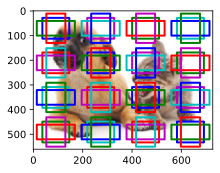

In [6]:
display_anchors(fmap_w=4, fmap_h=4, s=[0.15]) # s是原始占比？

# SSD

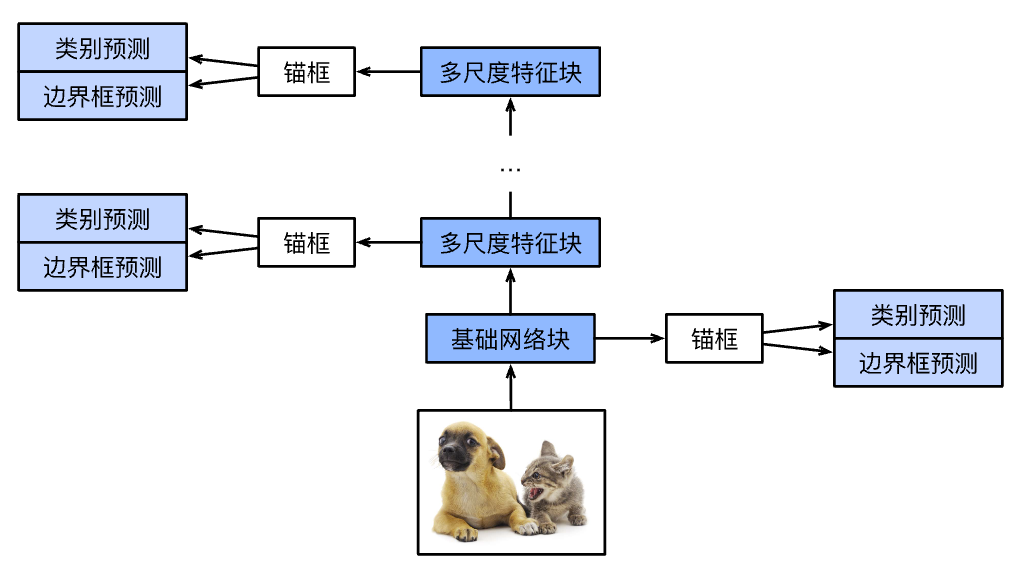

In [8]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

# 预测类别的
def cls_predictor(num_inputs, num_anchors, num_classes):
    # num_inputs 通道数 num_anchors 锚框数 num_classes 类别数
    return nn.Conv2d(num_inputs, num_anchors * (num_classes + 1), # 这里是输出的通道数，（加一个背景类，所以加1）
                     kernel_size=3, padding=1) # 用卷积做分类器，参考nin网络

### (**边界框预测层**)

#边界框预测层的设计与类别预测层的设计类似。
#唯一不同的是，这里需要为每个锚框预测4个偏移量，而不是$q+1$个类别。

# 预测偏离的
def bbox_predictor(num_inputs, num_anchors):
    return nn.Conv2d(num_inputs, num_anchors * 4, kernel_size=3, padding=1)

### [**连结多尺度的预测**]

正如我们所提到的，单发多框检测使用多尺度特征图来生成锚框并预测其类别和偏移量。
在不同的尺度下，特征图的形状或以同一单元为中心的锚框的数量可能会有所不同。
因此，不同尺度下预测输出的形状可能会有所不同。

在以下示例中，我们为同一个小批量构建两个不同比例（`Y1`和`Y2`）的特征图，其中`Y2`的高度和宽度是`Y1`的一半。
以类别预测为例，假设`Y1`和`Y2`的每个单元分别生成了$5$个和$3$个锚框。
进一步假设目标类别的数量为$10$，对于特征图`Y1`和`Y2`，类别预测输出中的通道数分别为$5\times(10+1)=55$和$3\times(10+1)=33$，其中任一输出的形状是（批量大小，通道数，高度，宽度）。

## 本来就有不同的比例，比例不同，导致最终维度不同

In [9]:
def forward(x, block):
    return block(x)

Y1 = forward(torch.zeros((2, 8, 20, 20)), cls_predictor(8, 5, 10))
Y2 = forward(torch.zeros((2, 16, 10, 10)), cls_predictor(16, 3, 10))
Y1.shape, Y2.shape

(torch.Size([2, 55, 20, 20]), torch.Size([2, 33, 10, 10]))

正如我们所看到的，除了批量大小这一维度外，其他三个维度都具有不同的尺寸。
为了将这两个预测输出链接起来以提高计算效率，我们将把这些张量转换为更一致的格式。

通道维包含中心相同的锚框的预测结果。我们首先将通道维移到最后一维。
因为不同尺度下批量大小仍保持不变，我们可以将预测结果转成二维的（批量大小，高$\times$宽$\times$通道数）的格式，以方便之后在维度$1$上的连结。

In [10]:
def flatten_pred(pred):
    return torch.flatten(pred.permute(0, 2, 3, 1), start_dim=1)

def concat_preds(preds):
    return torch.cat([flatten_pred(p) for p in preds], dim=1)

In [11]:
concat_preds([Y1, Y2]).shape

torch.Size([2, 25300])

### [**高和宽减半块**]

为了在多个尺度下检测目标，我们在下面定义了高和宽减半块`down_sample_blk`，该模块将输入特征图的高度和宽度减半。
事实上，该块应用了在 :numref:`subsec_vgg-blocks`中的VGG模块设计。
更具体地说，每个高和宽减半块由两个填充为$1$的$3\times3$的卷积层、以及步幅为$2$的$2\times2$最大汇聚层组成。
我们知道，填充为$1$的$3\times3$卷积层不改变特征图的形状。但是，其后的$2\times2$的最大汇聚层将输入特征图的高度和宽度减少了一半。
对于此高和宽减半块的输入和输出特征图，因为$1\times 2+(3-1)+(3-1)=6$，所以输出中的每个单元在输入上都有一个$6\times6$的感受野。因此，高和宽减半块会扩大每个单元在其输出特征图中的感受野。


In [12]:
def down_sample_blk(in_channels, out_channels):
    blk = []
    for _ in range(2):
        blk.append(nn.Conv2d(in_channels, out_channels,
                             kernel_size=3, padding=1))
        blk.append(nn.BatchNorm2d(out_channels))
        blk.append(nn.ReLU())
        in_channels = out_channels
    blk.append(nn.MaxPool2d(2))
    return nn.Sequential(*blk)

在以下示例中，我们构建的高和宽减半块会更改输入通道的数量，并将输入特征图的高度和宽度减半。


In [13]:
forward(torch.zeros((2, 3, 20, 20)), down_sample_blk(3, 10)).shape

torch.Size([2, 10, 10, 10])

### [**基本网络块**]

基本网络块用于从输入图像中抽取特征。
为了计算简洁，我们构造了一个小的基础网络，该网络串联3个高和宽减半块，并逐步将通道数翻倍。
给定输入图像的形状为$256\times256$，此基本网络块输出的特征图形状为$32 \times 32$（$256/2^3=32$）。

In [15]:
def base_net():
    blk = []
    num_filters = [3, 16, 32, 64]
    for i in range(len(num_filters) - 1):
        blk.append(down_sample_blk(num_filters[i], num_filters[i+1]))
    return nn.Sequential(*blk)

forward(torch.zeros((2, 3, 256, 256)), base_net()).shape

torch.Size([2, 64, 32, 32])

### 完整的模型

[**完整的单发多框检测模型由五个模块组成**]。每个块生成的特征图既用于生成锚框，又用于预测这些锚框的类别和偏移量。在这五个模块中，第一个是基本网络块，第二个到第四个是高和宽减半块，最后一个模块使用全局最大池将高度和宽度都降到1。从技术上讲，第二到第五个区块都是 :numref:`fig_ssd`中的多尺度特征块。


In [16]:
def get_blk(i):
    if i == 0:
        blk = base_net()
    elif i == 1:
        blk = down_sample_blk(64, 128)
    elif i == 4:
        blk = nn.AdaptiveMaxPool2d((1,1))
    else:
        blk = down_sample_blk(128, 128)
    return blk

现在我们[**为每个块定义前向传播**]。与图像分类任务不同，此处的输出包括：CNN特征图`Y`；在当前尺度下根据`Y`生成的锚框；预测的这些锚框的类别和偏移量（基于`Y`）。

In [17]:
def blk_forward(X, blk, size, ratio, cls_predictor, bbox_predictor):
    Y = blk(X)
    anchors = d2l.multibox_prior(Y, sizes=size, ratios=ratio)
    cls_preds = cls_predictor(Y)
    bbox_preds = bbox_predictor(Y)
    return (Y, anchors, cls_preds, bbox_preds)

回想一下，在 :numref:`fig_ssd`中，一个较接近顶部的多尺度特征块是用于检测较大目标的，因此需要生成更大的锚框。
在上面的前向传播中，在每个多尺度特征块上，我们通过调用的`multibox_prior`函数（见 :numref:`sec_anchor`）的`sizes`参数传递两个比例值的列表。
在下面，0.2和1.05之间的区间被均匀分成五个部分，以确定五个模块的在不同尺度下的较小值：0.2、0.37、0.54、0.71和0.88。
之后，他们较大的值由$\sqrt{0.2 \times 0.37} = 0.272$、$\sqrt{0.37 \times 0.54} = 0.447$等给出。

[~~超参数~~]

In [18]:
# 超参数
sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79],
         [0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5
num_anchors = len(sizes[0]) + len(ratios[0]) - 1

In [19]:
class TinySSD(nn.Module):
    def __init__(self, num_classes, **kwargs):
        super(TinySSD, self).__init__(**kwargs)
        self.num_classes = num_classes
        idx_to_in_channels = [64, 128, 128, 128, 128]
        for i in range(5):
            # 即赋值语句self.blk_i=get_blk(i)
            setattr(self, f'blk_{i}', get_blk(i))
            setattr(self, f'cls_{i}', cls_predictor(idx_to_in_channels[i],
                                                    num_anchors, num_classes))
            setattr(self, f'bbox_{i}', bbox_predictor(idx_to_in_channels[i],
                                                      num_anchors))

    def forward(self, X):
        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
        for i in range(5):
            # getattr(self,'blk_%d'%i)即访问self.blk_i
            X, anchors[i], cls_preds[i], bbox_preds[i] = blk_forward(
                X, getattr(self, f'blk_{i}'), sizes[i], ratios[i],
                getattr(self, f'cls_{i}'), getattr(self, f'bbox_{i}'))
        anchors = torch.cat(anchors, dim=1)
        cls_preds = concat_preds(cls_preds)
        cls_preds = cls_preds.reshape(
            cls_preds.shape[0], -1, self.num_classes + 1)
        bbox_preds = concat_preds(bbox_preds)
        return anchors, cls_preds, bbox_preds

我们[**创建一个模型实例，然后使用它**]对一个$256 \times 256$像素的小批量图像`X`(**执行前向传播**)。

如本节前面部分所示，第一个模块输出特征图的形状为$32 \times 32$。
回想一下，第二到第四个模块为高和宽减半块，第五个模块为全局汇聚层。
由于以特征图的每个单元为中心有$4$个锚框生成，因此在所有五个尺度下，每个图像总共生成$(32^2 + 16^2 + 8^2 + 4^2 + 1)\times 4 = 5444$个锚框。


In [20]:
net = TinySSD(num_classes=1)
X = torch.zeros((32, 3, 256, 256))
anchors, cls_preds, bbox_preds = net(X)

print('output anchors:', anchors.shape)
print('output class preds:', cls_preds.shape)
print('output bbox preds:', bbox_preds.shape)

output anchors: torch.Size([1, 5444, 4])
output class preds: torch.Size([32, 5444, 2])
output bbox preds: torch.Size([32, 21776])


# 训练

In [21]:
batch_size = 32
train_iter, _ = d2l.load_data_bananas(batch_size)

read 1000 training examples
read 100 validation examples


In [22]:
device, net = d2l.try_gpu(), TinySSD(num_classes=1)
trainer = torch.optim.SGD(net.parameters(), lr=0.2, weight_decay=5e-4)

### [**定义损失函数和评价函数**]

目标检测有两种类型的损失。
第一种有关锚框类别的损失：我们可以简单地复用之前图像分类问题里一直使用的交叉熵损失函数来计算；
第二种有关正类锚框偏移量的损失：预测偏移量是一个回归问题。
但是，对于这个回归问题，我们在这里不使用 :numref:`subsec_normal_distribution_and_squared_loss`中描述的平方损失，而是使用$L_1$范数损失，即预测值和真实值之差的绝对值。
掩码变量`bbox_masks`令负类锚框和填充锚框不参与损失的计算。
最后，我们将锚框类别和偏移量的损失相加，以获得模型的最终损失函数。

In [23]:
cls_loss = nn.CrossEntropyLoss(reduction='none')
bbox_loss = nn.L1Loss(reduction='none')

def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    batch_size, num_classes = cls_preds.shape[0], cls_preds.shape[2]
    cls = cls_loss(cls_preds.reshape(-1, num_classes),
                   cls_labels.reshape(-1)).reshape(batch_size, -1).mean(dim=1)
    bbox = bbox_loss(bbox_preds * bbox_masks, # mask这里用到
                     bbox_labels * bbox_masks).mean(dim=1)
    return cls + bbox # 可以加权的，简单就是这么相加
# 这里直接加就行了，很麻

In [25]:
def cls_eval(cls_preds, cls_labels):
    # 由于类别预测结果放在最后一维，argmax需要指定最后一维。
    return float((cls_preds.argmax(dim=-1).type(
        cls_labels.dtype) == cls_labels).sum())

def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return float((torch.abs((bbox_labels - bbox_preds) * bbox_masks)).sum())

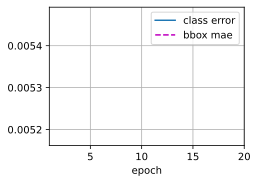

In [ ]:
num_epochs, timer = 20, d2l.Timer()
animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                        legend=['class error', 'bbox mae'])
net = net.to(device)
for epoch in range(num_epochs):
    # 训练精确度的和，训练精确度的和中的示例数
    # 绝对误差的和，绝对误差的和中的示例数
    metric = d2l.Accumulator(4)
    net.train()
    for features, target in train_iter:
        timer.start()
        trainer.zero_grad()
        X, Y = features.to(device), target.to(device)
        # 生成多尺度的锚框，为每个锚框预测类别和偏移量
        anchors, cls_preds, bbox_preds = net(X)
        # 为每个锚框标注类别和偏移量
        bbox_labels, bbox_masks, cls_labels = d2l.multibox_target(anchors, Y)
        # 根据类别和偏移量的预测和标注值计算损失函数
        l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels,
                      bbox_masks)
        l.mean().backward()
        trainer.step()
        metric.add(cls_eval(cls_preds, cls_labels), cls_labels.numel(),
                   bbox_eval(bbox_preds, bbox_labels, bbox_masks),
                   bbox_labels.numel())
    cls_err, bbox_mae = 1 - metric[0] / metric[1], metric[2] / metric[3]
    animator.add(epoch + 1, (cls_err, bbox_mae))
print(f'class err {cls_err:.2e}, bbox mae {bbox_mae:.2e}')
print(f'{len(train_iter.dataset) / timer.stop():.1f} examples/sec on '
      f'{str(device)}')

## 感觉理解了！！！

## [**预测目标**]

在预测阶段，我们希望能把图像里面所有我们感兴趣的目标检测出来。在下面，我们读取并调整测试图像的大小，然后将其转成卷积层需要的四维格式。


In [ ]:
X = torchvision.io.read_image('../img/banana.jpg').unsqueeze(0).float()
img = X.squeeze(0).permute(1, 2, 0).long()

In [ ]:
def predict(X):
    net.eval()
    anchors, cls_preds, bbox_preds = net(X.to(device))
    cls_probs = F.softmax(cls_preds, dim=2).permute(0, 2, 1)
    output = d2l.multibox_detection(cls_probs, bbox_preds, anchors)
    idx = [i for i, row in enumerate(output[0]) if row[0] != -1]
    return output[0, idx]
# nms 这个要跑一下
output = predict(X)

In [ ]:
def display(img, output, threshold):
    d2l.set_figsize((5, 5))
    fig = d2l.plt.imshow(img)
    for row in output:
        score = float(row[1])
        if score < threshold:
            continue
        h, w = img.shape[0:2]
        bbox = [row[2:6] * torch.tensor((w, h, w, h), device=row.device)]
        d2l.show_bboxes(fig.axes, bbox, '%.2f' % score, 'w')

display(img, output.cpu(), threshold=0.9)